<a href="https://colab.research.google.com/github/HaqTetsuya/rusdi-prototype-1/blob/greeting_test/rusdi_prototype_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Teks judul default
# Cell 1: Instalasi library yang diperlukan
!pip install transformers torch pandas scikit-learn matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# prompt: buat kode untuk request dari github HaqTetsuya/rusdi-prototype-1 namun di branch greeting_test dan download semua kode

!git clone -b greeting_test https://github.com/HaqTetsuya/rusdi-prototype-1.git




In [ ]:
# @title Cell 2: Import library yang diperlukan
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from google.colab import drive, files
import pickle
import torch.nn.functional as F
import json
import os
from tqdm import tqdm

In [ ]:
# @title Cell 3: Mount Google Drive untuk menyimpan model dan data
# Uncomment ini jika ingin menggunakan Google Drive

drive.mount('/content/drive')
MODEL_SAVE_PATH = "/content/drive/MyDrive/indobert_intent_model2"



# Cell 4: Kelas Dataset untuk IndoBERT
class IntentDataset(Dataset):
    """Dataset untuk klasifikasi intent dengan IndoBERT"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Convert dict of tensors to flat tensors
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)

        return item

Mounted at /content/drive


In [ ]:
# @title data
def load_data_from_csv(csv_path):
    """Memuat data intent dari file CSV dan menampilkan visualisasi distribusi intent"""
    print(f"Memuat data dari: {csv_path}")

    # Cek apakah file ada
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File CSV tidak ditemukan: {csv_path}")

    # Memuat data
    try:
        df = pd.read_csv(csv_path)
        print(f"Berhasil memuat {len(df)} baris data")
    except Exception as e:
        raise Exception(f"Error saat memuat file CSV: {str(e)}")

    # Cek kolom yang diperlukan
    required_columns = ['text', 'intent']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Kolom '{col}' tidak ditemukan dalam file CSV")

    # Mengonversi label intent menjadi angka
    label_encoder = LabelEncoder()
    df['intent_encoded'] = label_encoder.fit_transform(df['intent'])

    # Informasi tentang intent yang ditemukan
    intent_classes = label_encoder.classes_
    num_labels = len(intent_classes)
    print(f"Ditemukan {num_labels} intent berbeda dalam dataset")

    # Tampilkan distribusi intent
    intent_counts = df['intent'].value_counts()
    print("\nDistribusi intent:")
    for intent, count in intent_counts.items():
        print(f"  {intent}: {count} contoh")

    # **Visualisasi Distribusi Intent**
    plt.figure(figsize=(12, 5))

    # Bar Chart
    plt.subplot(1, 2, 1)
    sns.barplot(x=intent_counts.index, y=intent_counts.values, palette="viridis")
    plt.xlabel("Intent")
    plt.ylabel("Jumlah Sampel")
    plt.title("Distribusi Intent dalam Dataset")
    plt.xticks(rotation=45)

    # Pie Chart
    plt.subplot(1, 2, 2)
    plt.pie(intent_counts, labels=intent_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(intent_counts)))
    plt.title("Proporsi Intent dalam Dataset")

    # Tampilkan plot
    plt.tight_layout()
    plt.show()

    # Membagi data menjadi training dan validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['intent'])

    print(f"Data dibagi menjadi {len(train_df)} sampel training dan {len(val_df)} sampel validasi")

    # Menyiapkan data untuk pelatihan
    train_texts = train_df['text'].values
    train_labels = train_df['intent_encoded'].values
    val_texts = val_df['text'].values
    val_labels = val_df['intent_encoded'].values

    return train_texts, val_texts, train_labels, val_labels, intent_classes, num_labels, label_encoder

In [ ]:
# @title Cell 7: Fungsi untuk setup model IndoBERT
def setup_indobert_for_intent(num_labels):
    """Load model IndoBERT untuk klasifikasi intent"""

    print("Memuat model IndoBERT...")
    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
    model = AutoModelForSequenceClassification.from_pretrained(
        "indobenchmark/indobert-base-p1",
        num_labels=num_labels
    )
    print("Model berhasil dimuat")

    return model, tokenizer

In [ ]:
def calibrate_ood_detection(model, tokenizer, dataloader, temperature=1.0, percentile=95):
    """
    Kalibrasi threshold untuk OOD detection menggunakan data in-distribution
    dengan metode Energy-based dan MSP (Maximum Softmax Probability)
    """
    device = next(model.parameters()).device
    model.eval()

    # Untuk Energy method dan MSP method
    energy_scores = []
    msp_scores = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Kalibrasi OOD detection"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            logits = outputs.logits

            # Energy score (nilai lebih tinggi untuk OOD)
            energy = -temperature * torch.logsumexp(logits / temperature, dim=1)
            energy_scores.extend(energy.cpu().numpy())

            # MSP score (nilai lebih rendah untuk OOD)
            softmax_probs = F.softmax(logits, dim=1)
            max_probs, _ = torch.max(softmax_probs, dim=1)
            msp_scores.extend(max_probs.cpu().numpy())

    # Hitung threshold untuk Energy (maksimal energy untuk in-distribution)
    energy_threshold = np.percentile(energy_scores, percentile)

    # Hitung threshold untuk MSP (minimal probability untuk in-distribution)
    msp_threshold = np.percentile(msp_scores, 100 - percentile)  # Inverse percentile karena higher = better

    return {
        "energy_threshold": float(energy_threshold),
        "msp_threshold": float(msp_threshold)
    }

In [ ]:
def save_ood_thresholds(thresholds, save_path):
    """
    Menyimpan threshold OOD ke file JSON
    """
    threshold_file = os.path.join(save_path, "ood_thresholds.json")
    with open(threshold_file, 'w') as f:
        json.dump(thresholds, f, indent=4)
    print(f"OOD thresholds disimpan di {threshold_file}")
    return threshold_file

def load_ood_thresholds(model_path):
    """
    Memuat threshold OOD dari file JSON
    """
    # Coba load thresholds.json terlebih dahulu (format baru)
    try:
        with open(os.path.join(model_path, "ood_thresholds.json"), 'r') as f:
            thresholds = json.load(f)
            return thresholds
    except FileNotFoundError:
        # Jika tidak ditemukan, coba load format lama
        try:
            with open(os.path.join(model_path, "ood_threshold.json"), 'r') as f:
                threshold_data = json.load(f)
                return {
                    "energy_threshold": threshold_data["energy_threshold"],
                    "msp_threshold": None  # Tidak ada dalam format lama
                }
        except FileNotFoundError:
            print("Warning: OOD threshold files not found. Using default thresholds.")
            return {
                "energy_threshold": 0.0,  # Default fallback value
                "msp_threshold": 0.5  # Default fallback value
            }

In [ ]:
# @title cell 8: fungsi training
import os
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import get_scheduler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

def train_intent_classifier(model, tokenizer, train_texts, train_labels, val_texts, val_labels,
                           batch_size=16, epochs=10, learning_rate=2e-5, weight_decay=0.01,
                           save_path=MODEL_SAVE_PATH, use_class_weights=True, patience=3):
    """
    Melatih model IndoBERT untuk klasifikasi intent dengan perbaikan:
    - Early stopping
    - Weight decay untuk regularisasi
    - Class weights untuk mengatasi imbalance
    - Monitoring metrics yang lebih komprehensif (loss, accuracy, F1, precision, recall)
    - Learning rate scheduler yang lebih sophisticated
    """

    # Persiapkan dataset
    print("Menyiapkan dataset...")
    train_dataset = IntentDataset(train_texts, train_labels, tokenizer)
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Compute class weights if needed
    if use_class_weights:
        # Get unique classes
        unique_classes = np.unique(train_labels)
        # Compute weights
        weights = compute_class_weight(
            class_weight='balanced',
            classes=unique_classes,
            y=train_labels
        )
        # Convert to tensor
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        class_weights = torch.FloatTensor(weights).to(device)
        print(f"Menggunakan class weights: {weights}")
    else:
        class_weights = None

    # Optimizer dengan weight decay untuk regularisasi
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Scheduler dengan warmup
    num_training_steps = len(train_dataloader) * epochs
    num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup
    scheduler = get_scheduler("cosine", optimizer=optimizer,
                             num_warmup_steps=num_warmup_steps,
                             num_training_steps=num_training_steps)

    # Cek untuk GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Menggunakan device: {device}")
    model.to(device)
    print(f"Mulai pelatihan model...")
    print(f"Total epoch: {epochs}, batch size: {batch_size}, learning rate: {learning_rate}, weight decay: {weight_decay}")

    # Create loss function with class weights if needed
    if class_weights is not None:
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    else:
        loss_fn = torch.nn.CrossEntropyLoss()

    # Logging training
    best_val_loss = float('inf')
    counter = 0  # Counter for early stopping
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        tqdm.write(f"\nEpoch {epoch+1}/{epochs} - Training dimulai...")
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

        for batch in progress_bar:
            try:
                # Pindahkan batch ke device
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)

                # Forward pass with custom loss function
                optimizer.zero_grad()

                # Modified to use our loss function instead of the model's default
                outputs = model(**inputs)
                logits = outputs.logits
                loss = loss_fn(logits, labels)

                # Backward pass
                loss.backward()

                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()
                scheduler.step()

                train_loss += loss.item()
                progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

            except RuntimeError as e:
                if "out of memory" in str(e):
                    tqdm.write("Peringatan: Kehabisan memori! Membersihkan cache...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        avg_train_loss = train_loss / len(train_dataloader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        tqdm.write(f"Epoch {epoch+1}/{epochs} - Validasi dimulai...")
        progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

        with torch.no_grad():
            for batch in progress_bar:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)

                outputs = model(**inputs)
                logits = outputs.logits
                loss = loss_fn(logits, labels)
                val_loss += loss.item()

                # Hitung akurasi
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)

                # Collect predictions and labels for metrics
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

        # Calculate metrics
        avg_val_loss = val_loss / len(val_dataloader)
        accuracy = correct / total
        f1 = f1_score(all_labels, all_preds, average='weighted')
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

        # Save metrics to history
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(accuracy)
        history['val_f1'].append(f1)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)

        # Print detailed metrics
        tqdm.write(f"Epoch {epoch+1}/{epochs}:")
        tqdm.write(f"  Train Loss: {avg_train_loss:.4f}")
        tqdm.write(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy*100:.2f}%")
        tqdm.write(f"  Val F1: {f1:.4f}, Val Precision: {precision:.4f}, Val Recall: {recall:.4f}")

        # Early stopping and model saving logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0  # Reset early stopping counter

            if not os.path.exists(save_path):
                os.makedirs(save_path)

            tqdm.write(f"Menyimpan model terbaik ke {save_path}")
            model.save_pretrained(save_path)
            tokenizer.save_pretrained(save_path)

            # Save classification report for best model
            report = classification_report(all_labels, all_preds, output_dict=True)
            with open(os.path.join(save_path, "classification_report.json"), 'w') as f:
                json.dump(report, f, indent=4)
        else:
            counter += 1
            tqdm.write(f"Validation loss tidak membaik. Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                tqdm.write(f"Early stopping triggered setelah {epoch+1} epochs")
                break

    tqdm.write(f"Pelatihan selesai! Model terbaik disimpan di {save_path}")

    # Simpan history ke file JSON
    history_file = os.path.join(save_path, "training_history.json")
    with open(history_file, 'w') as f:
        json.dump(history, f)
    tqdm.write(f"History training disimpan di {history_file}")

    # Plot hasil training
    plot_training_results(history, save_path)

    return model, history

def enhanced_calibrate_ood(model, tokenizer, val_dataloader, save_path, temperature=1.0, percentile=95):
    """
    Kalibrasi dan simpan threshold OOD yang ditingkatkan
    """
    print("Kalibrasi threshold untuk OOD detection...")
    thresholds = calibrate_ood_detection(model, tokenizer, val_dataloader,
                                        temperature=temperature,
                                        percentile=percentile)

    print(f"Energy threshold: {thresholds['energy_threshold']:.4f}")
    print(f"MSP threshold: {thresholds['msp_threshold']:.4f}")

    # Save thresholds
    save_ood_thresholds(thresholds, save_path)

    return thresholds

def plot_training_results(history, save_path):
    """Plot dan simpan hasil training metrics"""
    plt.figure(figsize=(15, 10))

    # Plot 1: Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o', color='green')
    plt.title('Akurasi selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(history['val_f1'], label='Validation F1', marker='o', color='purple')
    plt.title('F1 Score selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    # Plot 4: Precision & Recall
    plt.subplot(2, 2, 4)
    plt.plot(history['val_precision'], label='Validation Precision', marker='o', color='orange')
    plt.plot(history['val_recall'], label='Validation Recall', marker='o', color='brown')
    plt.title('Precision & Recall selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(save_path, "training_metrics.png"))
    plt.show()

In [ ]:
# @title Cell 9: Fungsi untuk evaluasi model
def evaluate_model(model, tokenizer, val_texts, val_labels, intent_classes, batch_size=16):
    """Evaluasi model dan tampilkan confusion matrix dan metrics"""

    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluasi"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=intent_classes, digits=4)
    print("Classification Report:")
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=intent_classes, yticklabels=intent_classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return report, cm

In [ ]:
def predict_intent_with_enhanced_ood(text, model, tokenizer, intent_classes,
                                     energy_threshold, msp_threshold=None,
                                     temperature=1.0, method='combined',
                                     label_encoder=None, device=None,
                                     return_logits=False):
    """
    Memprediksi intent dari teks input dengan deteksi Out-of-Distribution yang ditingkatkan

    Args:
        text: Teks input untuk diprediksi
        model: Model yang sudah dilatih
        tokenizer: Tokenizer untuk model
        intent_classes: List nama intent
        energy_threshold: Threshold untuk energy-based OOD detection
        msp_threshold: Threshold untuk MSP-based OOD detection
        temperature: Parameter temperature untuk energy
        method: Metode deteksi OOD - 'energy', 'msp', atau 'combined'
        label_encoder: Label encoder untuk intent classes
        device: Device untuk inference
        return_logits: Jika True, mengembalikan logits asli

    Returns:
        dict: Hasil prediksi dengan detail OOD detection
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if isinstance(text, str):
        text = [text]  # Convert single text to list

    model.to(device)
    model.eval()

    # Tokenisasi input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    # List untuk menyimpan hasil setiap input
    results = []

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        # Hitung energy score: -T*log(sum(exp(logits/T)))
        energy = -temperature * torch.logsumexp(logits / temperature, dim=1)

        # Hitung confidence dengan softmax
        probabilities = torch.softmax(logits, dim=1)
        predictions = torch.argmax(probabilities, dim=1)
        max_probs = torch.max(probabilities, dim=1)[0]

        for i in range(len(text)):
            prediction = predictions[i].item()
            energy_score = energy[i].item()
            confidence = max_probs[i].item()

            # Deteksi OOD berdasarkan metode yang dipilih
            is_ood_energy = energy_score > energy_threshold if energy_threshold is not None else False
            is_ood_msp = confidence < msp_threshold if msp_threshold is not None else False

            if method == 'energy':
                is_ood = is_ood_energy
            elif method == 'msp':
                is_ood = is_ood_msp
            else:  # 'combined'
                is_ood = is_ood_energy or is_ood_msp

            # Tentukan intent berdasarkan hasil OOD detection
            if is_ood:
                predicted_intent = "unknown"
                topk_intents = [("unknown", 1.0)]  # Unknown intent dengan confidence 100%
            else:
                predicted_intent = intent_classes[prediction]

                # Dapatkan top 3 intent dengan confidence tertinggi
                top_k = min(3, len(intent_classes))
                topk_values, topk_indices = torch.topk(probabilities[i], top_k)
                topk_intents = [(intent_classes[idx.item()], val.item())
                                for idx, val in zip(topk_indices, topk_values)]

            # Buat hasil untuk input ini
            result = {
                "text": text[i],
                "intent": predicted_intent,
                "confidence": confidence,
                "energy_score": energy_score,
                "is_ood": is_ood,
                "is_ood_energy": is_ood_energy,
                "is_ood_msp": is_ood_msp if msp_threshold is not None else None,
                "top_intents": topk_intents
            }

            if return_logits:
                result["logits"] = logits[i].cpu().numpy()

            results.append(result)

    # Jika hanya satu input, kembalikan hasil langsung tanpa list
    if len(text) == 1:
        return results[0]
    return results

In [ ]:
def run_full_pipeline_enhanced(use_drive=True, percentile=95, ood_method='combined'):
    """Jalankan pipeline lengkap dengan enhanced OOD detection"""

    # Buat folder jika belum ada
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

    # 1. Buat atau muat dataset
    csv_file = "sample_intent_data.csv"

    # 2. Muat data
    train_texts, val_texts, train_labels, val_labels, intent_classes, num_labels, label_encoder = load_data_from_csv(csv_file)

    # 3. Setup model
    model, tokenizer = setup_indobert_for_intent(num_labels)

    # 4. Latih model
    model, history = train_intent_classifier(
        model,
        tokenizer,
        train_texts,
        train_labels,
        val_texts,
        val_labels,
        batch_size=16,
        epochs=10,
        learning_rate=2e-5,
        weight_decay=0.01,
        patience=3
    )

    # 5. Enhanced OOD calibration
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=16)
    thresholds = enhanced_calibrate_ood(model, tokenizer, val_dataloader, MODEL_SAVE_PATH, percentile=percentile)

    # 6. Evaluasi model
    report, cm = evaluate_model(model, tokenizer, val_texts, val_labels, intent_classes)

    # 7. Simpan intent classes & label encoder
    with open(f"{MODEL_SAVE_PATH}/intent_classes.pkl", "wb") as f:
        pickle.dump(intent_classes, f)

    with open(f"{MODEL_SAVE_PATH}/label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)

    print(f"\n✅ Model telah berhasil dilatih dan disimpan di {MODEL_SAVE_PATH}")
    print(f"Jumlah intent: {num_labels}")
    print(f"Intent yang didukung: {', '.join(intent_classes)}")
    print(f"OOD detection thresholds: Energy={thresholds['energy_threshold']:.4f}, MSP={thresholds['msp_threshold']:.4f}")

    # 8. Jalankan demo dengan metode OOD yang ditentukan
    run_prediction_demo_enhanced(model, tokenizer, intent_classes, label_encoder, method=ood_method)

    return model, tokenizer, intent_classes, label_encoder

In [ ]:
def run_prediction_demo_enhanced(model=None, tokenizer=None, intent_classes=None, label_encoder=None, model_path=None, method='combined'):
    """Jalankan demo prediksi intent dengan model yang telah dilatih dan enhanced OOD detection"""

    if model_path is None:
        model_path = MODEL_SAVE_PATH

    # Jika model tidak diberikan, muat dari path penyimpanan
    if model is None or tokenizer is None or intent_classes is None:
        if not os.path.exists(model_path):
            print(f"Error: Model tidak ditemukan di {model_path}")
            print("Jalankan run_full_pipeline() terlebih dahulu untuk melatih model")
            return

        # Muat model dan tokenizer
        print(f"Memuat model dari {model_path}...")
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained(model_path)

        # Muat intent classes
        import pickle
        with open(f"{model_path}/intent_classes.pkl", "rb") as f:
            intent_classes = pickle.load(f)
            print(f"Intent yang didukung: {', '.join(intent_classes)}")

    # Load OOD thresholds
    thresholds = load_ood_thresholds(model_path)
    energy_threshold = thresholds["energy_threshold"]
    msp_threshold = thresholds.get("msp_threshold")

    if msp_threshold is not None:
        print(f"OOD thresholds loaded: Energy={energy_threshold:.4f}, MSP={msp_threshold:.4f}")
    else:
        print(f"OOD thresholds loaded: Energy={energy_threshold:.4f}, MSP={msp_threshold}")

    print(f"Menggunakan metode deteksi OOD: {method}")

    print("\nDemo Prediksi Intent dengan Enhanced OOD Detection:")
    print("====================================================")

    # Prediksi input pengguna
    while True:
        user_input = input("\nMasukkan teks untuk prediksi intent (ketik 'exit' untuk keluar): ")
        if user_input.lower() == 'exit':
            break

        result = predict_intent_with_enhanced_ood(
            user_input,
            model,
            tokenizer,
            intent_classes,
            energy_threshold,
            msp_threshold,
            method=method
        )

        if result["is_ood"]:
            print(f"⚠️ Intent terdeteksi: unknown")
            print(f"   Energy score: {result['energy_score']:.4f} (threshold: {energy_threshold:.4f})")
            if msp_threshold:
                print(f"   Confidence score: {result['confidence']:.4f} (threshold: {msp_threshold:.4f})")
        else:
            print(f"✓ Intent terdeteksi: {result['intent']} (confidence: {result['confidence']:.4f})")

        print("\nTop 3 intent:")
        for i, (intent_name, score) in enumerate(result["top_intents"]):
            print(f"  {i+1}. {intent_name}: {score:.4f}")

        print("\nDetail OOD detection:")
        print(f"  Energy-based: {'OOD' if result['is_ood_energy'] else 'In-Distribution'} ({result['energy_score']:.4f})")
        if msp_threshold:
            print(f"  MSP-based: {'OOD' if result['is_ood_msp'] else 'In-Distribution'} ({result['confidence']:.4f})")
        print(f"  Final decision: {'OOD' if result['is_ood'] else 'In-Distribution'}")


Memuat data dari: sample_intent_data.csv
Berhasil memuat 2301 baris data
Ditemukan 4 intent berbeda dalam dataset

Distribusi intent:
  goodbye: 612 contoh
  denied: 581 contoh
  greeting: 559 contoh
  confirm: 549 contoh


<ipython-input-4-b63a65958955>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=intent_counts.index, y=intent_counts.values, palette="viridis")


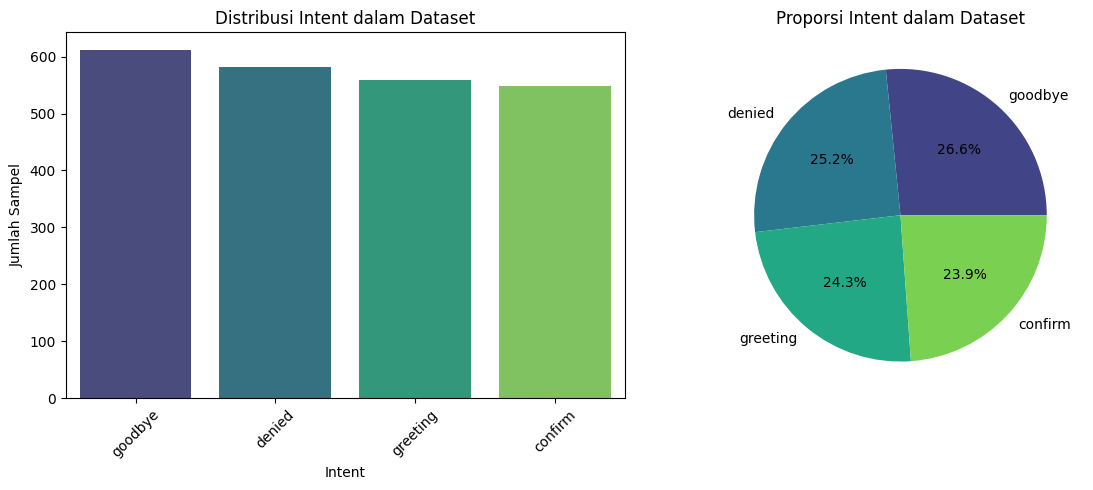

Data dibagi menjadi 1840 sampel training dan 461 sampel validasi
Memuat model IndoBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model berhasil dimuat
Menyiapkan dataset...
Menggunakan class weights: [1.04783599 0.98924731 0.9406953  1.02908277]
Menggunakan device: cuda
Mulai pelatihan model...
Total epoch: 10, batch size: 16, learning rate: 2e-05, weight decay: 0.01

Epoch 1/10 - Training dimulai...


Epoch 1/10 - Validasi dimulai...


Epoch 1/10:
  Train Loss: 0.9824
  Val Loss: 0.4322, Val Accuracy: 86.33%
  Val F1: 0.8621, Val Precision: 0.8699, Val Recall: 0.8633
Menyimpan model terbaik ke /content/drive/MyDrive/indobert_intent_model2

Epoch 2/10 - Training dimulai...


Epoch 2/10 - Validasi dimulai...


Epoch 2/10:
  Train Loss: 0.3317
  Val Loss: 0.2526, Val Accuracy: 91.76%
  Val F1: 0.9185, Val Precision: 0.9240, Val Recall: 0.9176
Menyimpan model terbaik ke /content/drive/MyDrive/indobert_intent_model2

Epoch 3/10 - Training dimulai...


Epoch 3/10 - Validasi dimulai...


Epoch 3/10:
  Train Loss: 0.1613
  Val Loss: 0.2600, Val Accuracy: 93.28%
  Val F1: 0.9330, Val Precision: 0.9341, Val Recall: 0.9328
Validation loss tidak membaik. Early stopping counter: 1/3

Epoch 4/10 - Training dimulai...


Epoch 4/10 - Validasi dimulai...


Epoch 4/10:
  Train Loss: 0.0823
  Val Loss: 0.2877, Val Accuracy: 93.06%
  Val F1: 0.9305, Val Precision: 0.9308, Val Recall: 0.9306
Validation loss tidak membaik. Early stopping counter: 2/3

Epoch 5/10 - Training dimulai...


Epoch 5/10 - Validasi dimulai...


Epoch 5/10:
  Train Loss: 0.0554
  Val Loss: 0.2524, Val Accuracy: 94.14%
  Val F1: 0.9416, Val Precision: 0.9424, Val Recall: 0.9414
Menyimpan model terbaik ke /content/drive/MyDrive/indobert_intent_model2

Epoch 6/10 - Training dimulai...


Epoch 6/10 - Validasi dimulai...


Epoch 6/10:
  Train Loss: 0.0374
  Val Loss: 0.3418, Val Accuracy: 92.41%
  Val F1: 0.9241, Val Precision: 0.9253, Val Recall: 0.9241
Validation loss tidak membaik. Early stopping counter: 1/3

Epoch 7/10 - Training dimulai...


Epoch 7/10 - Validasi dimulai...


Epoch 7/10:
  Train Loss: 0.0277
  Val Loss: 0.2907, Val Accuracy: 93.93%
  Val F1: 0.9394, Val Precision: 0.9408, Val Recall: 0.9393
Validation loss tidak membaik. Early stopping counter: 2/3

Epoch 8/10 - Training dimulai...


Epoch 8/10 - Validasi dimulai...


Epoch 8/10:
  Train Loss: 0.0252
  Val Loss: 0.2890, Val Accuracy: 94.58%
  Val F1: 0.9459, Val Precision: 0.9473, Val Recall: 0.9458
Validation loss tidak membaik. Early stopping counter: 3/3
Early stopping triggered setelah 8 epochs
Pelatihan selesai! Model terbaik disimpan di /content/drive/MyDrive/indobert_intent_model2
History training disimpan di /content/drive/MyDrive/indobert_intent_model2/training_history.json


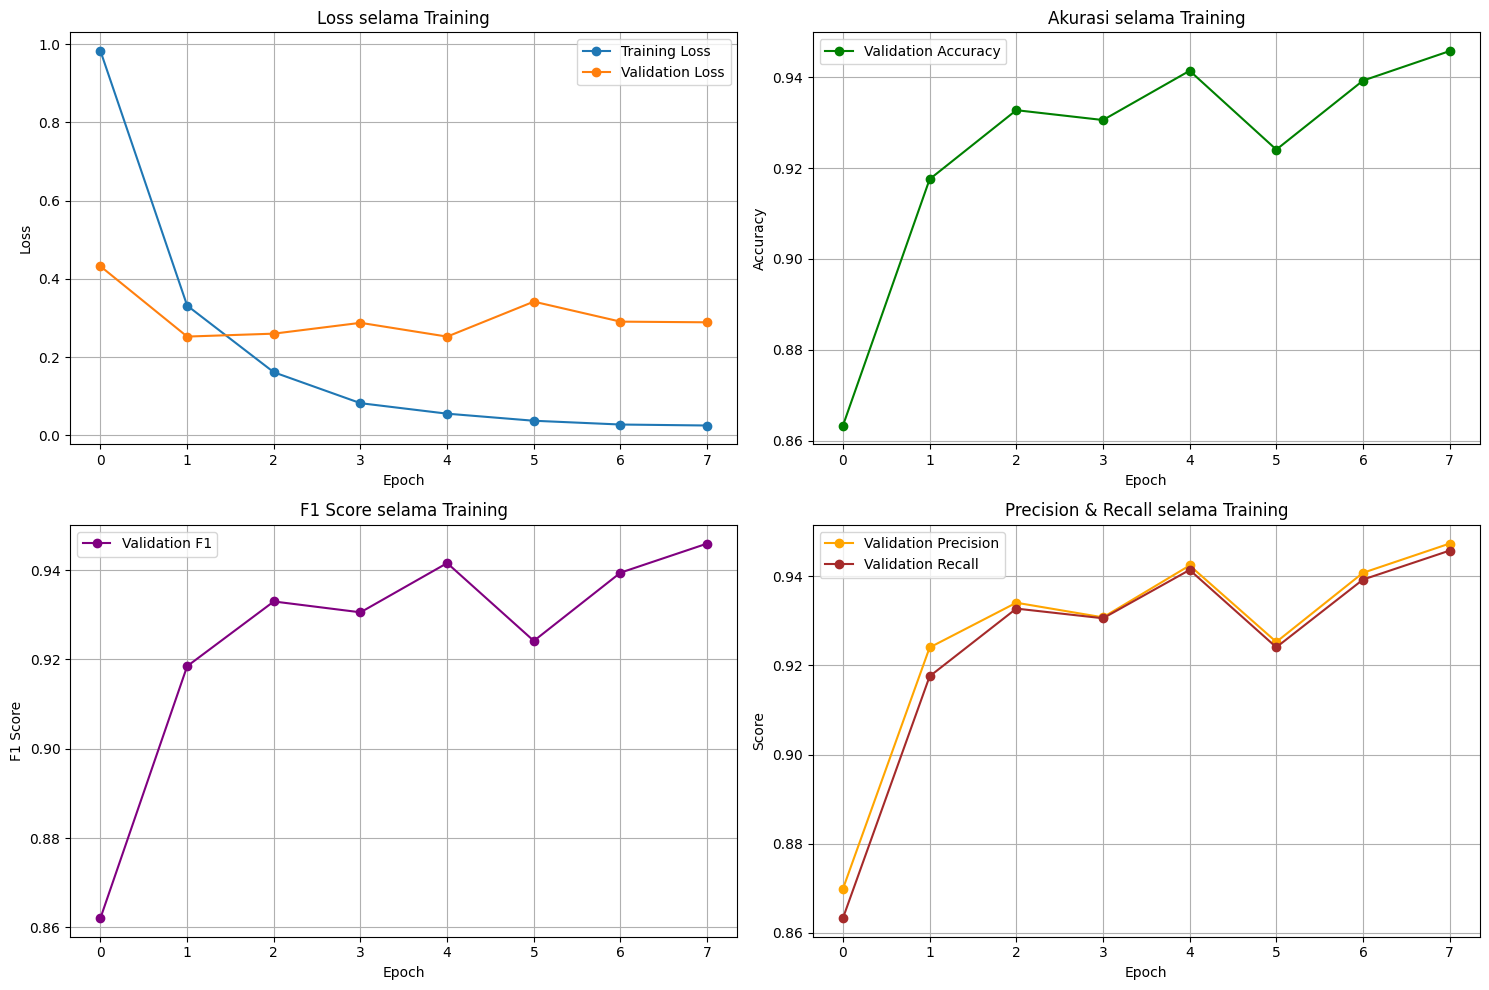

Kalibrasi threshold untuk OOD detection...


Kalibrasi OOD detection: 100%|██████████| 29/29 [00:03<00:00,  8.93it/s]


Energy threshold: -4.1165
MSP threshold: 0.9440
OOD thresholds disimpan di /content/drive/MyDrive/indobert_intent_model2/ood_thresholds.json


Evaluasi: 100%|██████████| 29/29 [00:03<00:00,  8.84it/s]


Classification Report:
              precision    recall  f1-score   support

     confirm     0.9000    0.9818    0.9391       110
      denied     0.9391    0.9310    0.9351       116
     goodbye     0.9829    0.9350    0.9583       123
    greeting     0.9633    0.9375    0.9502       112

    accuracy                         0.9458       461
   macro avg     0.9463    0.9463    0.9457       461
weighted avg     0.9473    0.9458    0.9459       461



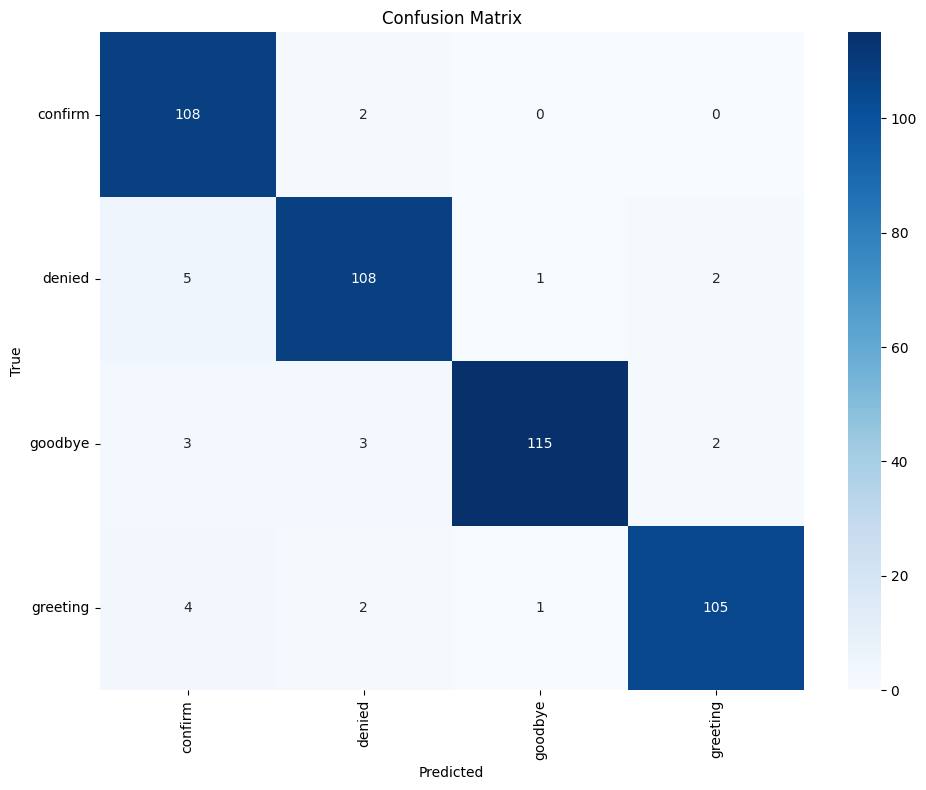


✅ Model telah berhasil dilatih dan disimpan di /content/drive/MyDrive/indobert_intent_model2
Jumlah intent: 4
Intent yang didukung: confirm, denied, goodbye, greeting
OOD detection thresholds: Energy=-4.1165, MSP=0.9440
OOD thresholds loaded: Energy=-4.1165, MSP=0.9440
Menggunakan metode deteksi OOD: combined

Demo Prediksi Intent dengan Enhanced OOD Detection:

Masukkan teks untuk prediksi intent (ketik 'exit' untuk keluar): buaya putih sungai musi
✓ Intent terdeteksi: greeting (confidence: 0.9965)

Top 3 intent:
  1. greeting: 0.9965
  2. denied: 0.0023
  3. goodbye: 0.0006

Detail OOD detection:
  Energy-based: In-Distribution (-5.4926)
  MSP-based: In-Distribution (0.9965)
  Final decision: In-Distribution

Masukkan teks untuk prediksi intent (ketik 'exit' untuk keluar): lumpur lapindo blukutuk blukutuk
⚠️ Intent terdeteksi: unknown
   Energy score: -3.9309 (threshold: -4.1165)
   Confidence score: 0.9872 (threshold: 0.9440)

Top 3 intent:
  1. unknown: 1.0000

Detail OOD detectio

In [ ]:
# Cell 13: Jalankan pipeline (uncomment untuk menjalankan)

model, tokenizer, intent_classes, label_encoder = run_full_pipeline_enhanced(
    percentile=95,  # Adjust OOD sensitivity (higher = more strict)
    ood_method='combined'  # Use 'energy', 'msp', or 'combined'
)


# Cell 14: Jalankan demo prediksi (uncomment untuk menjalankan)


In [26]:
# If you want to load an existing model and run predictions
run_prediction_demo_enhanced(
    model_path=MODEL_SAVE_PATH,  # Your MODEL_SAVE_PATH
    method='combined'  # Which OOD detection method to use
)

Memuat model dari /content/drive/MyDrive/indobert_intent_model2...
Intent yang didukung: confirm, denied, goodbye, greeting
OOD thresholds loaded: Energy=-4.1165, MSP=0.9440
Menggunakan metode deteksi OOD: combined

Demo Prediksi Intent dengan Enhanced OOD Detection:

Masukkan teks untuk prediksi intent (ketik 'exit' untuk keluar): kapal karam
⚠️ Intent terdeteksi: unknown
   Energy score: -3.8272 (threshold: -4.1165)
   Confidence score: 0.8154 (threshold: 0.9440)

Top 3 intent:
  1. unknown: 1.0000

Detail OOD detection:
  Energy-based: OOD (-3.8272)
  MSP-based: OOD (0.8154)
  Final decision: OOD

Masukkan teks untuk prediksi intent (ketik 'exit' untuk keluar): aku pergi
✓ Intent terdeteksi: goodbye (confidence: 0.9986)

Top 3 intent:
  1. goodbye: 0.9986
  2. confirm: 0.0006
  3. greeting: 0.0005

Detail OOD detection:
  Energy-based: In-Distribution (-5.7804)
  MSP-based: In-Distribution (0.9986)
  Final decision: In-Distribution

Masukkan teks untuk prediksi intent (ketik 'exit' 

In [ ]:
import pandas as pd
import random
import nltk
from deep_translator import GoogleTranslator
from nltk.corpus import wordnet
from collections import defaultdict
import os

nltk.download('omw-1.4')
nltk.download('wordnet')

# Load dataset
file_path = "/content/aaaa.xlsx"  # Ganti dengan path file XLSX
csv_path = file_path.replace(".xlsx", ".csv")  # Buat path CSV

# Konversi XLSX ke CSV jika diperlukan
if file_path.endswith(".xlsx"):
    df = pd.read_excel(file_path)
    df.to_csv(csv_path, index=False)
    print(f"✅ File dikonversi ke CSV: {csv_path}")
else:
    df = pd.read_csv(file_path)

# Fungsi mendapatkan sinonim dari WordNet
def get_synonym(word):
    synonyms = set()
    for syn in wordnet.synsets(word, lang='ind'):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

# Fungsi mengganti kata dengan sinonim
def replace_with_synonym(sentence):
    words = sentence.split()
    new_words = [random.choice(get_synonym(word)) if get_synonym(word) else word for word in words]
    return " ".join(new_words)

# Fungsi backtranslation
def back_translate(sentence):
    translated = GoogleTranslator(source='id', target='en').translate(sentence)
    return GoogleTranslator(source='en', target='id').translate(translated)

# Fungsi menambahkan typo
def add_typo(sentence):
    chars = list(sentence)
    if len(chars) > 3:
        idx = random.randint(0, len(chars) - 1)
        chars[idx] = random.choice("abcdefghijklmnopqrstuvwxyz")
    return "".join(chars)

# Fungsi random deletion
def random_deletion(sentence, p=0.3):
    words = sentence.split()
    if len(words) == 1:
        return sentence
    new_words = [word for word in words if random.uniform(0, 1) > p]
    return " ".join(new_words) if new_words else random.choice(words)

# Fungsi random swap
def random_swap(sentence, n=1):
    words = sentence.split()
    if len(words) < 2:
        return sentence
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return " ".join(words)

# Fungsi phonetic augmentation
def phonetic_augmentation(sentence):
    phonetic_dict = {
        "saya": "sy", "kamu": "km", "oke": "ok", "ga": "g", "ya": "y",
        "dong": "dongz", "bro": "brow", "please": "plis", "bisa": "bs", "selamat": "slmt"
    }
    words = sentence.split()
    new_words = [phonetic_dict[word] if word in phonetic_dict else word for word in words]
    return " ".join(new_words)

# Fungsi menambahkan kata atau frasa umum
def add_common_phrase(sentence):
    common_phrases = ["ya", "anjay", "dong", "cuy", "bro", "lah", "plis", "eh"]
    return sentence + " " + random.choice(common_phrases)

# Fungsi augmentasi data
def augment_data(text):
    augmented_texts = [
        text,
        replace_with_synonym(text),
        back_translate(text),
        add_typo(text),
        random_deletion(text),
        random_swap(text),
        phonetic_augmentation(text),
        add_common_phrase(text)
    ]
    return list(set(augmented_texts))  # Hindari duplikasi

# Proses augmentasi
df_augmented = []
for _, row in df.iterrows():
    texts = augment_data(row['text'])
    for new_text in texts:
        df_augmented.append([new_text, row['intent']])

df_augmented = pd.DataFrame(df_augmented, columns=["text", "intent"])
output_path = "/content/sample_intent_data.csv"
df_augmented.to_csv(output_path, index=False)

# Statistik Augmentasi
print("✅ Augmentasi selesai! Dataset baru tersimpan sebagai 'sample_intent_data.csv'.")
print(f"📌 Jumlah data sebelum augmentasi: {len(df)}")
print(f"📌 Jumlah data setelah augmentasi: {len(df_augmented)}")


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


✅ File dikonversi ke CSV: /content/aaaa.csv
✅ Augmentasi selesai! Dataset baru tersimpan sebagai 'sample_intent_data.csv'.
📌 Jumlah data sebelum augmentasi: 400
📌 Jumlah data setelah augmentasi: 2301


In [ ]:
!pip install deep-translator


In [ ]:
# prompt: the model already trained and saved to drive, but can i test the model without running thee training.

# Path ke folder model di Google Drive
model_path = "/content/drive/MyDrive/indobert_intent_model"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load intent classes
with open(f"{model_path}/intent_classes.pkl", "rb") as f:
    intent_classes = pickle.load(f)

# Load label encoder (jika diperlukan)
with open(f"{model_path}/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


def predict_intent(text, model, tokenizer, intent_classes, device=None):
    """Memprediksi intent dari teks input"""

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    # Tokenisasi input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][prediction].item()

    predicted_intent = intent_classes[prediction]

    # Dapatkan top 3 intent dengan confidence tertinggi
    top_k = 3
    if len(intent_classes) < top_k:
        top_k = len(intent_classes)

    topk_values, topk_indices = torch.topk(probabilities, top_k, dim=1)
    topk_intents = [(intent_classes[idx.item()], val.item()) for idx, val in zip(topk_indices[0], topk_values[0])]

    return predicted_intent, confidence, topk_intents


# Contoh penggunaan
    while True:
        user_input = input("\nMasukkan teks untuk prediksi intent (ketik 'exit' untuk keluar): ")
        if user_input.lower() == 'exit':
            break

        intent, confidence, topk = predict_intent(user_input, model, tokenizer, intent_classes)
        print(f"Intent terdeteksi: {intent} (confidence: {confidence:.4f})")
        print("Top 3 intent:")
        for i, (intent_name, score) in enumerate(topk):
            print(f"  {i+1}. {intent_name}: {score:.4f}")



In [ ]:
# prompt: xlsx to csv convert

import pandas as pd

# Replace 'input.xlsx' with the actual path to your Excel file
excel_file = 'input.xlsx'

# Replace 'output.csv' with the desired path and name for your CSV file
csv_file = 'output.csv'

try:
  # Read the Excel file into a Pandas DataFrame
  df = pd.read_excel(excel_file)

  # Convert the DataFrame to a CSV file
  df.to_csv(csv_file, index=False)

  print(f"Successfully converted '{excel_file}' to '{csv_file}'")

except FileNotFoundError:
  print(f"Error: File '{excel_file}' not found.")
except Exception as e:
  print(f"An error occurred: {e}")


In [ ]:
!git status


On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	rusdi-prototype-1/

nothing added to commit but untracked files present (use "git add" to track)
